# How should we call edSites?

serveral previous appers use unified genotyper - but this assumes ploidy. This is not a good assumption for editing sites. We compare with mutect2, which is designed to detect somatic mutation and can handle lower fractions. 

Mutect2 detects RNA-DNA differences, which will be somatic mutations as well as editing. This will differ based on
1. haplotype consistency. edSites will fall on both haplotypes, somatic mutation will always be on one.
2. sharing across individuals. Lots of samples will have the same editing sites. Somatic mutation will be more evenly distributed


compare to sites from REDIPortal v3

In [12]:
import pandas as pd
from cyvcf2 import VCF
import upsetplot as up
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

load in an example output from each for a single sample. This is pre-filtering (so likely lots of false positives)

In [13]:
sample_id = "GTEX-11DXX-0002-SM-HTQ7V"

In [14]:
hc_vcf_path = f'/home/klawren/oak/gtex/output/all_tissues/haplotype_caller/{sample_id}.hc.vcf.gz'
hc_filtered_vcf_path = f'/home/klawren/oak/gtex/output/all_tissues/haplotype_caller/{sample_id}.hc.filtered.vcf.gz'
hc_filtered_regions_vcf_path = f'/home/klawren/oak/gtex/output/all_tissues/haplotype_caller/{sample_id}.hc.filtered_regions.vcf.gz'
mutect_vcf_path = f'/home/klawren/oak/gtex/output/all_tissues/mutect/{sample_id}.mutect2.filtered.vcf'
mutect_filtered_vcf_path = f'/home/klawren/oak/gtex/output/all_tissues//mutect/{sample_id}.mutect2.filtered_regions.vcf'

In [62]:
hc_vcf['FILTER']

0         .
1         .
2         .
3         .
4         .
         ..
214590    .
214591    .
214592    .
214593    .
214594    .
Name: FILTER, Length: 195892, dtype: object

In [ ]:
def load_hc(hc_path):
    hc_vcf = pd.read_csv(hc_path, comment='#', sep='\t', names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    hc_vcf['AF'] = hc_vcf['INFO'].str.split('AF=').str[1].str.split(';').str[0]
    hc_vcf['in'] = True

    # split alternate alleles
    hc_vcf['ALT'] = hc_vcf['ALT'].str.split(',')
    hc_vcf['AF'] = hc_vcf['AF'].str.split(',')
    hc_vcf = hc_vcf.explode(['ALT', 'AF'])
    hc_vcf['AF']  = hc_vcf['AF'].astype(float)
    hc_vcf['ref_alt'] = hc_vcf['REF'] + '->' + hc_vcf['ALT']

    # just snps
    hc_vcf = hc_vcf[(hc_vcf['REF'].isin(['A', 'C', 'T', 'G'])) & (hc_vcf['ALT'].isin(['A', 'C', 'T', 'G']))]
    return hc_vcf


orig_hc_vcf = load_hc(hc_vcf_path)
hc_filtered_vcf = load_hc(hc_filtered_vcf_path)
hc_filtered_regions_vcf = load_hc(hc_filtered_regions_vcf_path)

# add in filter
hc_vcf = pd.merge(orig_hc_vcf, hc_filtered_regions_vcf[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'in']], on=['CHROM', 'POS', 'REF', 'ALT'], how='left', suffixes=['', '_filtered'])
hc_vcf['FILTER'] = np.where((hc_vcf['in_filtered']==True), 'PASS', 'FAIL')

In [54]:
# load in mutect (filter is just a tag)

def load_mutect(mutect_path):
    mutect_vcf = pd.read_csv(mutect_path, comment='#', sep='\t', names=['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'SAMPLE'])
    mutect_vcf['in'] = True
    mutect_vcf['AF'] = mutect_vcf['SAMPLE'].str.split(':').str[2]

    # split alternate alleles
    mutect_vcf['ALT'] = mutect_vcf['ALT'].str.split(',')
    mutect_vcf['AF'] = mutect_vcf['AF'].str.split(',')
    mutect_vcf = mutect_vcf.explode(['ALT', 'AF'])
    mutect_vcf['AF']  = mutect_vcf['AF'].astype(float)
    mutect_vcf['ref_alt'] = mutect_vcf['REF'] + '->' + mutect_vcf['ALT']

    # just snps
    mutect_vcf = mutect_vcf[(mutect_vcf['REF'].isin(['A', 'C', 'T', 'G'])) & (mutect_vcf['ALT'].isin(['A', 'C', 'T', 'G']))]
    return mutect_vcf

orig_mutect_vcf = load_mutect(mutect_vcf_path)
mutect_filtered_vcf = load_mutect(mutect_filtered_vcf_path)

# add in region filter
mutect_vcf = pd.merge(orig_mutect_vcf, mutect_filtered_vcf[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'in']], on=['CHROM', 'POS', 'REF', 'ALT'], how='left', suffixes=['', '_regions'])
mutect_vcf['FILTER'] = np.where(~(mutect_vcf['in_regions']==True), mutect_vcf['FILTER'] + ';excluded_region', mutect_vcf['FILTER'])

mutect_vcf['FILTER_split'] = mutect_vcf['FILTER'].str.split(';')
mutect_vcf.explode('FILTER_split')['FILTER_split'].value_counts()


FILTER_split
clustered_events    131500
haplotype           123202
PASS                 94960
fragment             50058
panel_of_normals     47604
weak_evidence        32153
position             14627
base_qual            10914
excluded_region       9729
multiallelic           494
strand_bias            325
contamination           17
Name: count, dtype: int64

combine the vcf to see which variants are discovered by one tool or the other

In [55]:
combined_vcf = pd.merge(mutect_vcf, hc_vcf, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', suffixes=['_mutect', '_hc'])
combined_vcf['in_hc'] = combined_vcf['in_hc'] == True
combined_vcf['in_mutect'] = combined_vcf['in_mutect'] == True
combined_vcf['combined_in'] = np.where(combined_vcf['in_hc'], np.where(combined_vcf['in_mutect'], 'both', 'hc_only'), 'mutect_only')

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

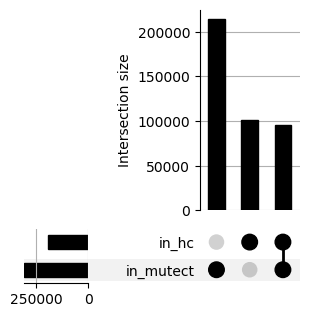

In [56]:
var_upset = up.UpSet(combined_vcf.set_index('in_hc').set_index('in_mutect', append=True))
var_upset.plot()

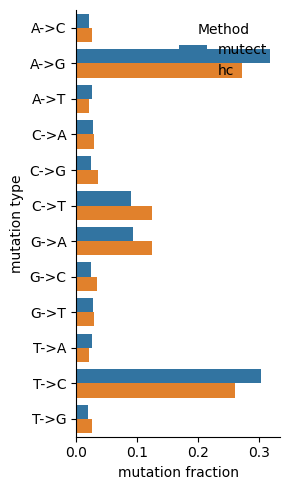

62.13% of mutect2 are A>G or T>C
53.30% of haplotype caller are A>G or T>C


In [57]:
mutect_counts = pd.DataFrame(mutect_vcf.groupby(['REF', 'ALT']).size()).reset_index()
mutect_counts['method'] = 'mutect'
mutect_counts['fraction'] = mutect_counts[0]/mutect_counts[0].sum()

hc_counts = pd.DataFrame(hc_vcf[(hc_vcf['REF'].isin(['A', 'C', 'T', 'G'])) & (hc_vcf['ALT'].isin(['A', 'C', 'T', 'G']))].groupby(['REF', 'ALT']).size()).reset_index()
hc_counts['method'] = 'hc'
hc_counts['fraction'] = hc_counts[0]/hc_counts[0].sum()


ref_alt_counts = pd.concat([mutect_counts, hc_counts])
ref_alt_counts['ref_alt'] = ref_alt_counts['REF'] + '->' + ref_alt_counts['ALT']

fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(
    data=ref_alt_counts,
    y="ref_alt",
    x="fraction",
    hue="method",
    dodge=True,
    ax=ax,
)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, title='Method')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel("mutation fraction")
ax.set_ylabel("mutation type")
plt.tight_layout()
plt.show()

print('{:.2f}% of mutect2 are A>G or T>C'.format(ref_alt_counts[(ref_alt_counts['ref_alt'].isin(['A->G', 'T->C'])) & (ref_alt_counts['method']=='mutect')]['fraction'].sum()*100))
print('{:.2f}% of haplotype caller are A>G or T>C'.format(ref_alt_counts[(ref_alt_counts['ref_alt'].isin(['A->G', 'T->C'])) & (ref_alt_counts['method']=='hc')]['fraction'].sum()*100))

look at the allele frequencies of the variants

/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


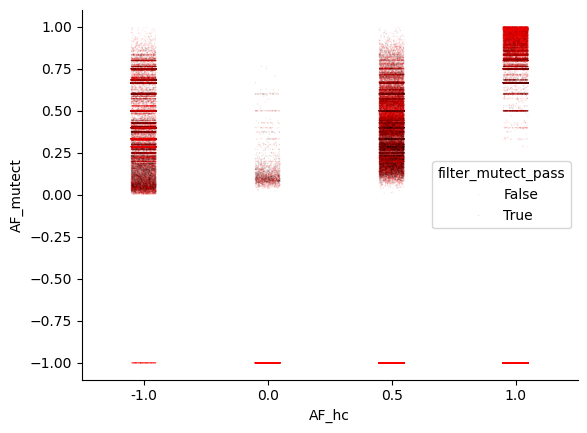

In [58]:
combined_vcf['AF_hc'] = combined_vcf['AF_hc'].fillna(-1)
combined_vcf['AF_mutect'] = combined_vcf['AF_mutect'].fillna(-1)
combined_vcf['filter_mutect_pass'] = combined_vcf['FILTER_mutect'] == 'PASS'

sns.stripplot(combined_vcf, x='AF_hc', y='AF_mutect', alpha=.1, s=1, hue='filter_mutect_pass', palette={False:'red', True:'k'})
sns.despine()

how does mutation spectrum change post filtering?

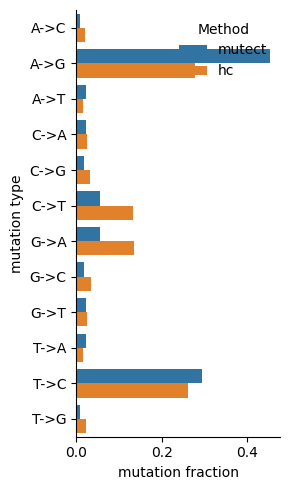

74.69% of filtered mutect2 are A>G or T>C
53.78% of filtered haplotype caller are A>G or T>C


In [59]:
mutect_counts = pd.DataFrame(mutect_vcf[mutect_vcf['FILTER']=='PASS'].groupby(['REF', 'ALT']).size()).reset_index()
mutect_counts['method'] = 'mutect'
mutect_counts['fraction'] = mutect_counts[0]/mutect_counts[0].sum()

hc_counts = pd.DataFrame(hc_filtered_regions_vcf.groupby(['REF', 'ALT']).size()).reset_index()
hc_counts['method'] = 'hc'
hc_counts['fraction'] = hc_counts[0]/hc_counts[0].sum()


ref_alt_counts = pd.concat([mutect_counts, hc_counts])
ref_alt_counts['ref_alt'] = ref_alt_counts['REF'] + '->' + ref_alt_counts['ALT']

fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(
    data=ref_alt_counts,
    y="ref_alt",
    x="fraction",
    hue="method",
    dodge=True,
    ax=ax,
)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, title='Method')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel("mutation fraction")
ax.set_ylabel("mutation type")
plt.tight_layout()
plt.show()

print('{:.2f}% of filtered mutect2 are A>G or T>C'.format(ref_alt_counts[(ref_alt_counts['ref_alt'].isin(['A->G', 'T->C'])) & (ref_alt_counts['method']=='mutect')]['fraction'].sum()*100))
print('{:.2f}% of filtered haplotype caller are A>G or T>C'.format(ref_alt_counts[(ref_alt_counts['ref_alt'].isin(['A->G', 'T->C'])) & (ref_alt_counts['method']=='hc')]['fraction'].sum()*100))

In [60]:
combined_vcf

,CHROM,POS,ID_mutect,REF,ALT,QUAL_mutect,FILTER_mutect,INFO_mutect,FORMAT_mutect,SAMPLE_mutect,...,QUAL_hc,FILTER_hc,INFO_hc,FORMAT_hc,SAMPLE_hc,AF_hc,in_hc,ref_alt_hc,combined_in,filter_mutect_pass
0,chr1,14522,.,G,A,.,clustered_events,"AS_FilterStatus=SITE;AS_SB_TABLE=9,0|2,0;DP=11...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/1:9,2:0.230:11:4,0:2,2:9,2:9,0,2,0",...,43.64,.,AC=1;AF=0.500;AN=2;BaseQRankSum=2.287;DB;DP=11...,GT:AD:DP:GQ:PL,"0/1:8,2:10:51:51,0,161",0.5,True,G->A,both,False
1,chr1,14542,.,A,G,.,clustered_events,"AS_FilterStatus=SITE;AS_SB_TABLE=1,1|7,0;DP=11...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/1:2,7:0.736:9:0,4:1,3:2,7:1,1,7,0",...,227.64,.,AC=1;AF=0.500;AN=2;BaseQRankSum=-1.732;DB;DP=1...,GT:AD:DP:GQ:PL,"0/1:2,7:9:52:235,0,52",0.5,True,A->G,both,False
2,chr1,14574,.,A,G,.,clustered_events,"AS_FilterStatus=SITE;AS_SB_TABLE=6,8|4,0;DP=19...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/1:14,4:0.248:18:1,3:5,1:14,4:6,8,4,0",...,48.64,.,AC=1;AF=0.500;AN=2;BaseQRankSum=-2.953;DB;DP=1...,GT:AD:DP:GQ:PL,"0/1:14,4:18:56:56,0,482",0.5,True,A->G,both,False
3,chr1,14653,.,C,T,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=16,3|13,3;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/1:19,16:0.477:35:10,7:6,9:18,16:16,3,13,3",...,490.64,.,AC=1;AF=0.500;AN=2;BaseQRankSum=2.452;DB;DP=37...,GT:AD:DP:GQ:PL,"0/1:19,16:35:99:498,0,512",0.5,True,C->T,both,True
4,chr1,14677,.,G,A,.,PASS,"AS_FilterStatus=SITE;AS_SB_TABLE=31,6|15,6;DP=...",GT:AD:AF:DP:F1R2:F2R1:FAD:SB,"0/1:37,21:0.356:58:16,10:19,10:37,20:31,6,15,6",...,587.64,.,AC=1;AF=0.500;AN=2;BaseQRankSum=1.699;DB;DP=64...,GT:AD:DP:GQ:PL,"0/1:37,21:58:99:595,0,1178",0.5,True,G->A,both,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409965,chrY,26629232,.,C,T,.,clustered_events;haplotype,"AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;DP=1;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|1:0,1:0.667:1:0,0:0,0:0,1:0|1:26629232_C_T:2...",...,NaN,NaN,NaN,NaN,NaN,-1.0,False,NaN,mutect_only,False
409966,chrY,26629240,.,A,G,.,clustered_events;haplotype,"AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;DP=1;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|1:0,1:0.667:1:0,0:0,0:0,1:0|1:26629232_C_T:2...",...,NaN,NaN,NaN,NaN,NaN,-1.0,False,NaN,mutect_only,False
409967,chrY,26629246,.,T,C,.,clustered_events;haplotype,"AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;DP=1;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|1:0,1:0.667:1:0,0:0,0:0,1:0|1:26629232_C_T:2...",...,NaN,NaN,NaN,NaN,NaN,-1.0,False,NaN,mutect_only,False
409968,chrY,26629250,.,T,C,.,clustered_events;haplotype,"AS_FilterStatus=SITE;AS_SB_TABLE=0,0|0,0;DP=1;...",GT:AD:AF:DP:F1R2:F2R1:FAD:PGT:PID:PS:SB,"0|1:0,1:0.667:1:0,0:0,0:0,1:0|1:26629232_C_T:2...",...,NaN,NaN,NaN,NaN,NaN,-1.0,False,NaN,mutect_only,False


In [ ]:
# which filters are causing  us to lose the overlap?

var_upset = up.UpSet(combined_vcf.set_index('in_hc').set_index('in_mutect', append=True))
var_upset.plot()

how does this change post filtering?

In [14]:
# go to only snps
mutect_filtered_final = mutect_filtered_vcf[(mutect_filtered_vcf['FILTER']=='PASS') & (mutect_filtered_vcf['REF'].apply(len)==1) & (mutect_filtered_vcf['ALT'].apply(len)==1)]
hc_filtered_final = hc_filtered_regions_vcf[(hc_filtered_regions_vcf['REF'].apply(len)==1) & (hc_filtered_regions_vcf['ALT'].apply(len)==1)]

haplotype caller initally: 91059
	post (basic) filtering: 18757
	post (basic + regions) filtering: 18261
	post (snps) filtering: 16175
mutect initally: 196552
	post (basic) filtering: 70324
	post (regions) filtering: 189863
	post (regions + basic) filtering: 67936
	post (snps) filtering: 60645

In [15]:
print('haplotype caller initally: {}'.format(len(hc_vcf)))
print('\tpost (basic) filtering: {}'.format(len(hc_filtered_vcf)))
print('\tpost (basic + regions) filtering: {}'.format(len(hc_filtered_regions_vcf)))
print('\tpost (snps) filtering: {}'.format(len(hc_filtered_final)))



print('mutect initally: {}'.format(len(mutect_vcf)))
print('\tpost (basic) filtering: {}'.format(sum(mutect_vcf['FILTER']=='PASS')))
print('\tpost (regions) filtering: {}'.format(len(mutect_filtered_vcf)))
print('\tpost (regions + basic) filtering: {}'.format(sum(mutect_filtered_vcf['FILTER']=='PASS')))
print('\tpost (snps) filtering: {}'.format(len(mutect_filtered_final)))


haplotype caller initally: 215788
	post (basic) filtering: 55123
	post (basic + regions) filtering: 53755
	post (snps) filtering: 48586
mutect initally: 380684
	post (basic) filtering: 111721
	post (regions) filtering: 367839
	post (regions + basic) filtering: 107893
	post (snps) filtering: 91905


In [16]:
combined_filtered_vcf = pd.merge(mutect_filtered_final, hc_filtered_final, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', suffixes=['_mutect', '_hc'])
combined_filtered_vcf['in_hc'] = combined_filtered_vcf['in_hc'] == True
combined_filtered_vcf['in_mutect'] = combined_filtered_vcf['in_mutect'] == True
combined_filtered_vcf['combined_in'] = np.where(combined_filtered_vcf['in_hc'], np.where(combined_filtered_vcf['in_mutect'], 'both', 'hc_only'), 'mutect_only')

In [17]:
mutect_counts = pd.DataFrame(mutect_filtered_final.groupby(['REF', 'ALT']).size()).reset_index()
mutect_counts['method'] = 'mutect'
mutect_counts['fraction'] = mutect_counts[0]/mutect_counts[0].sum()

hc_counts = pd.DataFrame(hc_filtered_final.groupby(['REF', 'ALT']).size()).reset_index()
hc_counts['method'] = 'hc'
hc_counts['fraction'] = hc_counts[0]/hc_counts[0].sum()


ref_alt_counts = pd.concat([mutect_counts, hc_counts])
ref_alt_counts['ref_alt'] = ref_alt_counts['REF'] + '->' + ref_alt_counts['ALT']


In [18]:
ref_alt_counts

,REF,ALT,0,method,fraction,ref_alt
0,A,C,782,mutect,0.008509,A->C
1,A,G,41697,mutect,0.453697,A->G
2,A,T,2005,mutect,0.021816,A->T
3,C,A,2037,mutect,0.022164,C->A
4,C,G,1601,mutect,0.017420,C->G
5,C,T,5187,mutect,0.056439,C->T
6,G,A,5100,mutect,0.055492,G->A
7,G,C,1639,mutect,0.017834,G->C
8,G,T,2072,mutect,0.022545,G->T
9,T,A,2047,mutect,0.022273,T->A


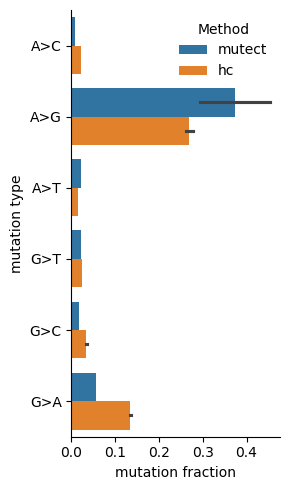

In [20]:
# complement map
comp = {"A":"T","T":"A","C":"G","G":"C"}

ref_alt_counts["pair"] = np.where(ref_alt_counts['REF'].isin(["A","G"]), ref_alt_counts['REF'] + ">" +ref_alt_counts['ALT'], 
    ref_alt_counts['REF'].map(comp) + ">" + ref_alt_counts['ALT'].map(comp))

fig, ax = plt.subplots(figsize=(3,5))
sns.barplot(
    data=ref_alt_counts,
    y="pair",
    x="fraction",
    hue="method",
    dodge=True,
    ax=ax,
)

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1), frameon=False, title='Method')
ax.spines[['top', 'right']].set_visible(False)

ax.set_xlabel("mutation fraction")
ax.set_ylabel("mutation type")
plt.tight_layout()
plt.show()

In [ ]:
print('{:.2f}% of mutect2 are A>G or T>C'.format(ref_alt_counts[(ref_alt_counts['pair'] å== 'A>G') & (ref_alt_counts['method']=='mutect')]['fraction'].sum()*100))
print('{:.2f}% of haplotype caller are A>G or T>C'.format(ref_alt_counts[(ref_alt_counts['pair'] == 'A>G') & (ref_alt_counts['method']=='hc')]['fraction'].sum()*100))


74.69% of mutect2 are A>G or T>C
53.78% of haplotype caller are A>G or T>C


/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/klawren/.pixi/envs/python/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

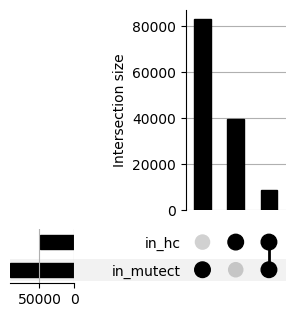

In [22]:
var_upset = up.UpSet(combined_filtered_vcf.set_index('in_hc').set_index('in_mutect', append=True))
var_upset.plot()

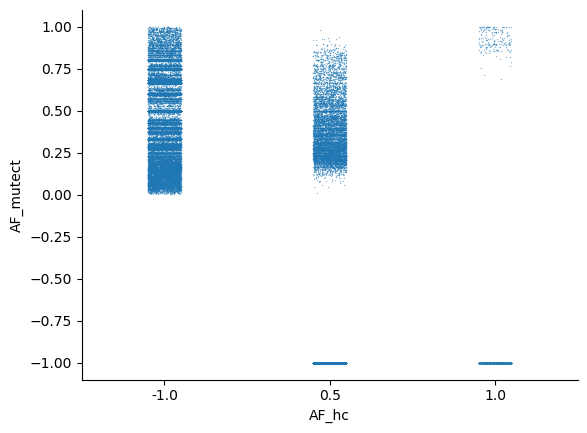

In [23]:
combined_filtered_vcf['AF_hc'] = combined_filtered_vcf['AF_hc'].fillna(-1)
combined_filtered_vcf['AF_mutect'] = combined_filtered_vcf['AF_mutect'].fillna(-1)

sns.stripplot(combined_filtered_vcf, x='AF_hc', y='AF_mutect', alpha=.5, s=1)
sns.despine()

In [24]:
combined_filtered_vcf['REF'].unique()

array(['G', 'A', 'C', 'T'], dtype=object)

How many of these are "true"? pull in rediportal data?

In [ ]:
redi_sites = pd.read_csv("/home/klawren/oak/gtex/data/edsite_references/REDIportal.positions.hg38_v3.txt", sep='\t')

redi_sites['in_redi'] = True
combined_vcf = pd.merge(combined_vcf, redi_sites, left_on=['CHROM', 'POS', 'REF', 'ALT'], right_on=['Chromosome', 'Position', 'Ref', 'Edit'], how='left')
combined_vcf['in_redi'] = combined_vcf['in_redi'].fillna(False)
combined_vcf['in_hc'] = combined_vcf['in_hc'].fillna(False)
combined_vcf['in_mutect'] = combined_vcf['in_mutect'].fillna(False)

/local/scratch/klawren/slrmtmp.48494591/ipykernel_46640/357967787.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_vcf['in_redi'] = combined_vcf['in_redi'].fillna(False)
